>     Predicting Air pressure system failures in Scania trucks
The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurized air that is utilized in various functions in a truck, such as braking and gear changes. The datasets' positive class consists of component failures for a specific component of the APS system. The negative class consists of trucks with failures for components not related to the APS.
The training set contains 60000 examples in total in which 59000 belong to the negative class and 1000 positive class. The test set contains 16000 examples. There are 171 attributes per record.

In [1]:
#Import required libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import scikitplot as skplot
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


/kaggle/input/aps-failure-at-scania-trucks-data-set/aps_failure_test_set_processed_8bit.csv
/kaggle/input/aps-failure-at-scania-trucks-data-set/aps_failure_description.txt
/kaggle/input/aps-failure-at-scania-trucks-data-set/aps_failure_training_set_processed_8bit.csv
/kaggle/input/aps-failure-at-scania-trucks-data-set/aps_failure_training_set.csv
/kaggle/input/aps-failure-at-scania-trucks-data-set/aps_failure_test_set.csv


Load the datasets

In [2]:
df_train=pd.read_csv("../input/aps-failure-at-scania-trucks-data-set/aps_failure_training_set_processed_8bit.csv")
df_test=pd.read_csv("../input/aps-failure-at-scania-trucks-data-set/aps_failure_test_set_processed_8bit.csv")
print("Shape of the datasets...")
print("Shape of train dataset:",df_train.shape)
print("Shape of the test dataset:",df_test.shape)

Shape of the datasets...
Shape of train dataset: (60000, 171)
Shape of the test dataset: (16000, 171)


In [3]:
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-0.992188,0.117188,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.687500,0.515625,0.234375,0.070312,0.007812,-0.109375,-0.140625,-0.171875,-0.023438,-0.023438
1,-0.992188,-0.179688,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.023438,-0.062500,-0.132812,-0.132812,-0.187500,-0.148438,-0.085938,-0.140625,-0.023438,-0.023438
2,-0.992188,-0.125000,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.140625,-0.093750,-0.015625,0.015625,-0.007812,-0.109375,-0.093750,-0.164062,-0.023438,-0.023438
3,-0.992188,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.007812,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,0.890625,0.992188
4,-0.992188,0.007812,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.156250,0.031250,-0.031250,-0.039062,-0.046875,-0.015625,0.656250,-0.148438,-0.023438,-0.023438


In [4]:
df_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-0.992188,-0.406250,-0.289062,-0.46875,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
1,-0.992188,-0.406250,-0.289062,-0.46875,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
2,-0.992188,0.046875,0.554688,-0.46875,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.046875,0.312500,-0.000000,-0.109375,0.914062,-0.109375,-0.304688,-0.171875,-0.023438,-0.023438
3,-0.992188,0.000000,-0.289062,-0.46875,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.085938,0.062500,0.031250,0.085938,0.093750,-0.078125,0.320312,-0.109375,-0.023438,-0.023438
4,-0.992188,-0.390625,-0.289062,-0.46875,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.375000,-0.375000,-0.359375,-0.304688,-0.304688,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438


In [5]:
#Concanate train & test dataset
dataset=pd.concat(objs=[df_train.drop(columns=["class"]),df_test.drop(columns=["class"])],axis=0)
dataset.shape

(76000, 170)

In [6]:
dataset.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.117188,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,-0.117188,...,0.687500,0.515625,0.234375,0.070312,0.007812,-0.109375,-0.140625,-0.171875,-0.023438,-0.023438
1,-0.179688,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,-0.117188,...,-0.023438,-0.062500,-0.132812,-0.132812,-0.187500,-0.148438,-0.085938,-0.140625,-0.023438,-0.023438
2,-0.125000,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,-0.117188,...,-0.140625,-0.093750,-0.015625,0.015625,-0.007812,-0.109375,-0.093750,-0.164062,-0.023438,-0.023438
3,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.007812,-0.007812,-0.03125,-0.054688,-0.117188,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,0.890625,0.992188
4,0.007812,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,-0.117188,...,0.156250,0.031250,-0.031250,-0.039062,-0.046875,-0.015625,0.656250,-0.148438,-0.023438,-0.023438


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76000 entries, 0 to 15999
Columns: 170 entries, aa_000 to eg_000
dtypes: float64(170)
memory usage: 99.2 MB


In [8]:
dataset.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,...,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000
mean,-0.123457,-0.068506,-0.204456,-0.007744,-0.032901,-0.039935,-0.006538,-0.025861,-0.040086,-0.073948,...,-0.104035,-0.098011,-0.093929,-0.088263,-0.102654,-0.087985,-0.084783,-0.067596,-0.019900,-0.018338
std,0.368933,0.354247,0.559990,0.003686,0.108952,0.114069,0.032640,0.067743,0.108607,0.189024,...,0.356875,0.362312,0.363698,0.337173,0.321224,0.239546,0.363531,0.261067,0.052789,0.062205
min,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.382812,-0.382812,-0.382812,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
25%,-0.398438,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.382812,-0.382812,-0.375000,-0.343750,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
50%,-0.195312,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.179688,-0.179688,-0.187500,-0.179688,-0.226562,-0.171875,-0.296875,-0.171875,-0.023438,-0.023438
75%,-0.070312,0.000000,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.007812,0.015625,0.017578,0.007812,-0.054688,-0.101562,0.000000,-0.132812,-0.023438,-0.023438
max,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,...,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188


Detecting missing  values

In [9]:
total_miss_values=dataset.isna().sum().sort_values(ascending=False)
total_miss_values

eg_000    0
ba_001    0
ba_009    0
ba_008    0
ba_007    0
         ..
cq_000    0
cp_000    0
co_000    0
cn_009    0
aa_000    0
Length: 170, dtype: int64

It seems no missing values are present in the dataset.

In [10]:
#Encode labels to 0 & 1
le=LabelEncoder()
df_train["class"]=le.fit_transform(df_train["class"])
df_test["class"]=le.transform(df_test["class"])
print("Target labels are :",le.classes_);

Target labels are : [-0.9921875  0.9921875]


Target labels, 0- Negative class &  1-positve class
                   

Visualzing the distribution of a dataset

> Data visulization with Correlation matrix

In [11]:
#Correlation matrix
df_train.corr()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
class,1.000000,0.365403,0.058041,0.022262,0.021464,0.006438,0.006316,0.120302,0.429994,0.496954,...,0.304754,0.285730,0.279020,0.299252,0.296514,0.273094,0.078735,0.048790,0.038260,0.024845
aa_000,0.365403,1.000000,0.121999,0.091271,0.025188,0.110415,0.115131,0.067289,0.185408,0.327367,...,0.867362,0.861476,0.839020,0.839522,0.823592,0.714641,0.488417,0.302424,0.048662,0.025319
ab_000,0.058041,0.121999,1.000000,0.015372,0.011020,-0.017268,-0.016700,0.016740,0.042054,0.064040,...,0.139755,0.124066,0.115553,0.118397,0.103143,0.103732,0.034100,0.021730,0.011490,0.004143
ac_000,0.022262,0.091271,0.015372,1.000000,0.005124,0.007997,0.007327,0.021513,0.022585,0.022782,...,0.102385,0.104665,0.097855,0.097390,0.083394,0.066857,0.072585,0.047044,0.011207,0.017086
ad_000,0.021464,0.025188,0.011020,0.005124,1.000000,-0.001366,-0.001411,0.006440,0.016721,0.017864,...,0.028775,0.023424,0.020111,0.016272,0.013391,0.015753,0.004279,0.003246,0.000651,0.000069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.273094,0.714641,0.103732,0.066857,0.015753,0.124427,0.128893,0.043951,0.160518,0.354358,...,0.595695,0.580086,0.556076,0.600210,0.766848,1.000000,0.374890,0.187208,0.036857,0.017779
ee_008,0.078735,0.488417,0.034100,0.072585,0.004279,-0.058660,-0.057943,0.017027,0.021267,0.024793,...,0.480937,0.482618,0.449890,0.473259,0.483717,0.374890,1.000000,0.780811,-0.025096,-0.035292
ee_009,0.048790,0.302424,0.021730,0.047044,0.003246,-0.049432,-0.049671,-0.000373,-0.020576,-0.045709,...,0.295910,0.292490,0.266447,0.272294,0.268450,0.187208,0.780811,1.000000,-0.018435,-0.024006
ef_000,0.038260,0.048662,0.011490,0.011207,0.000651,0.221157,0.218371,0.004524,0.019810,0.047570,...,0.019257,0.017986,0.010572,0.021801,0.046217,0.036857,-0.025096,-0.018435,1.000000,0.632963


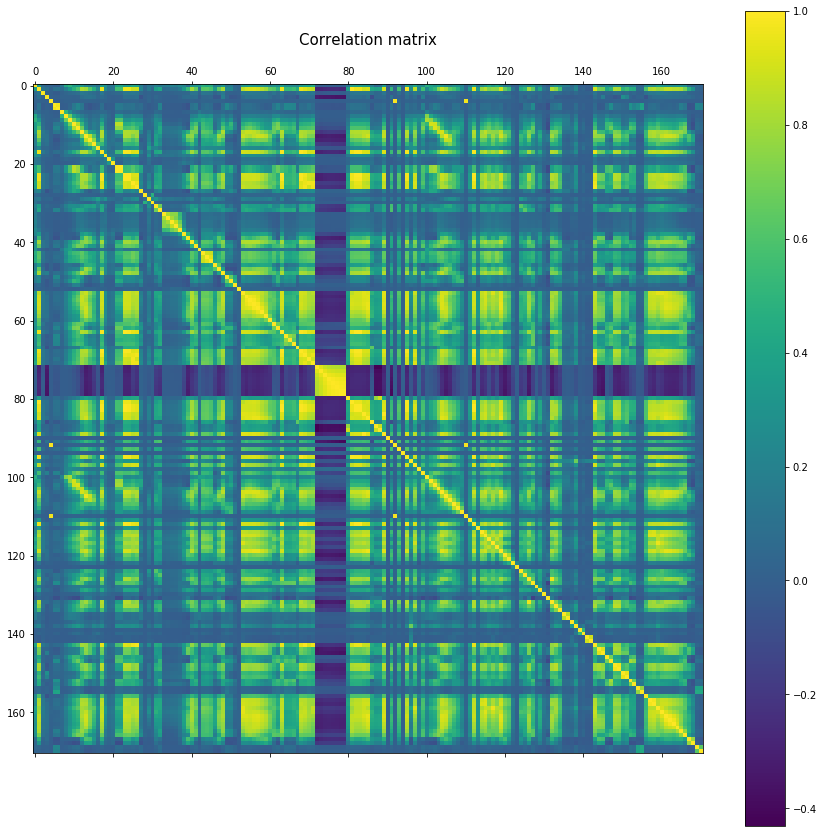

In [12]:
#plot correlation matrix
f=plt.figure(figsize=(15,15))
ax=f.add_subplot(111)
cax=ax.matshow(df_train.corr(),interpolation='nearest')
f.colorbar(cax)
plt.title('Correlation matrix',fontsize=15)
plt.show();

The above plot clearly shows that, in 171 attributes, the atributes numbered from 70 to 80 are negatively correlated with other attributes.

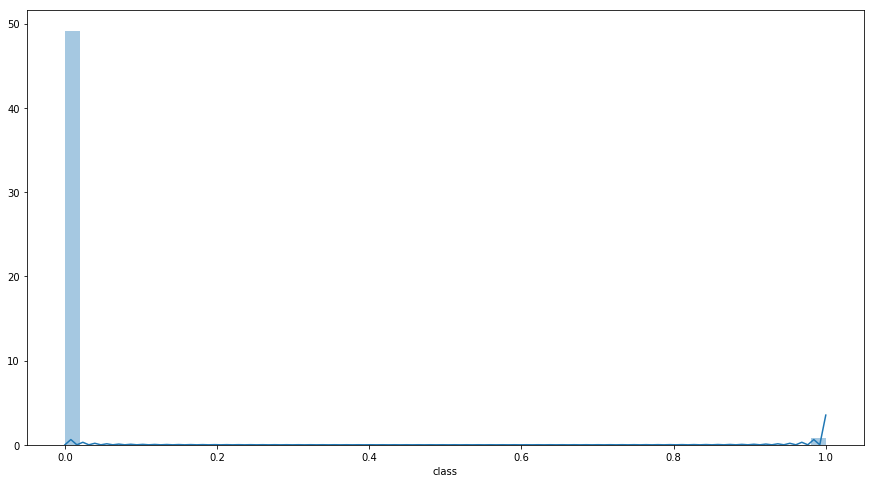

In [13]:
#Train dataset target labels distribution
plt.figure(figsize=(15,8))
sns.distplot(df_train["class"]);

This clearly shows that the target labels in train dataset are imbalanced i.e., negative samples are more than the positve samples. This dataset needs to be balanced to get accurate prediction results.

> Split the datasets

In [14]:
# Train dataset
X_train=df_train.drop(columns=["class"])
y_train=df_train["class"]

#Test dataset
X_test=df_test.drop(columns=["class"])
y_test=df_test["class"]

> SMOTE (Synthetic minority over sampling technique) Algorithm        
  - Used to balance the classes in the datasets

In [15]:
sm=SMOTE(random_state=42)
#Resample the train dataset
X_train,y_train=sm.fit_sample(X_train,y_train)
print("Resampled train dataset shape :",X_train.shape,y_train.shape);

Resampled train dataset shape : (118000, 170) (118000,)


Visualzing the distributon of the resampled dataset

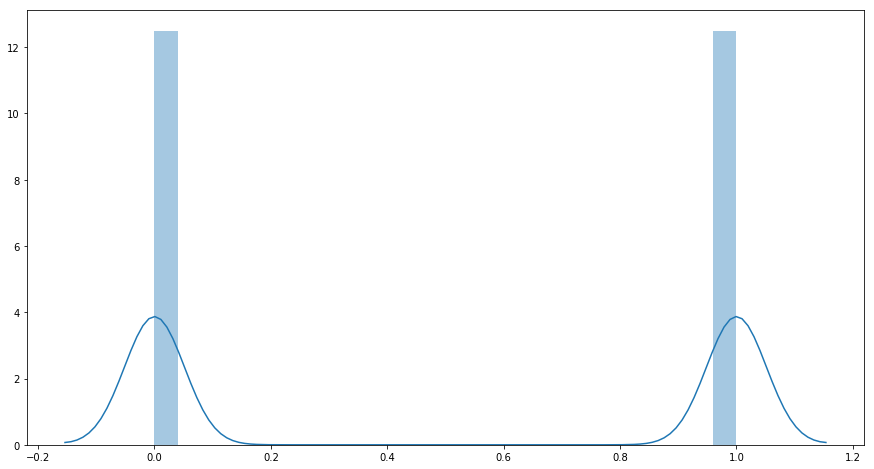

In [16]:
# distribution of classes in train dataset
plt.figure(figsize=(15,8))
sns.distplot(y_train);

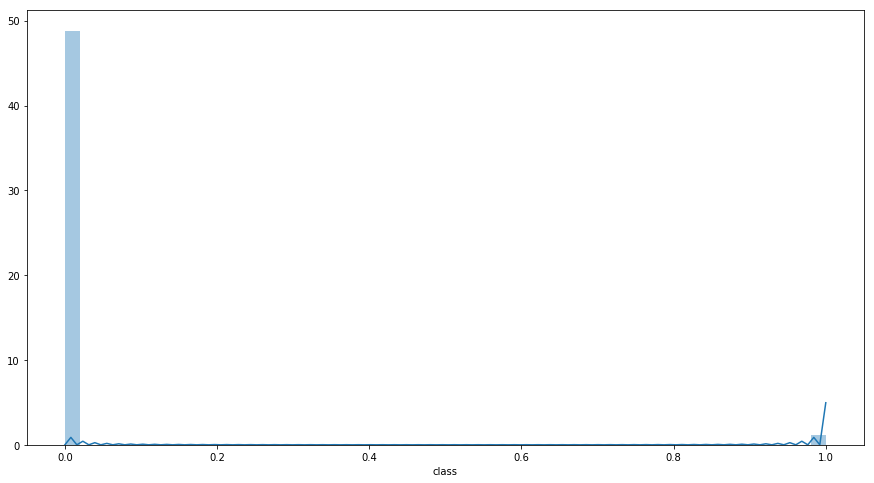

In [17]:
# distribution of classes in test dataset
plt.figure(figsize=(15,8))
sns.distplot(y_test);

After the resampling, the classes in train dataset are balanced.

> Visualizing the distribution of attributes/features

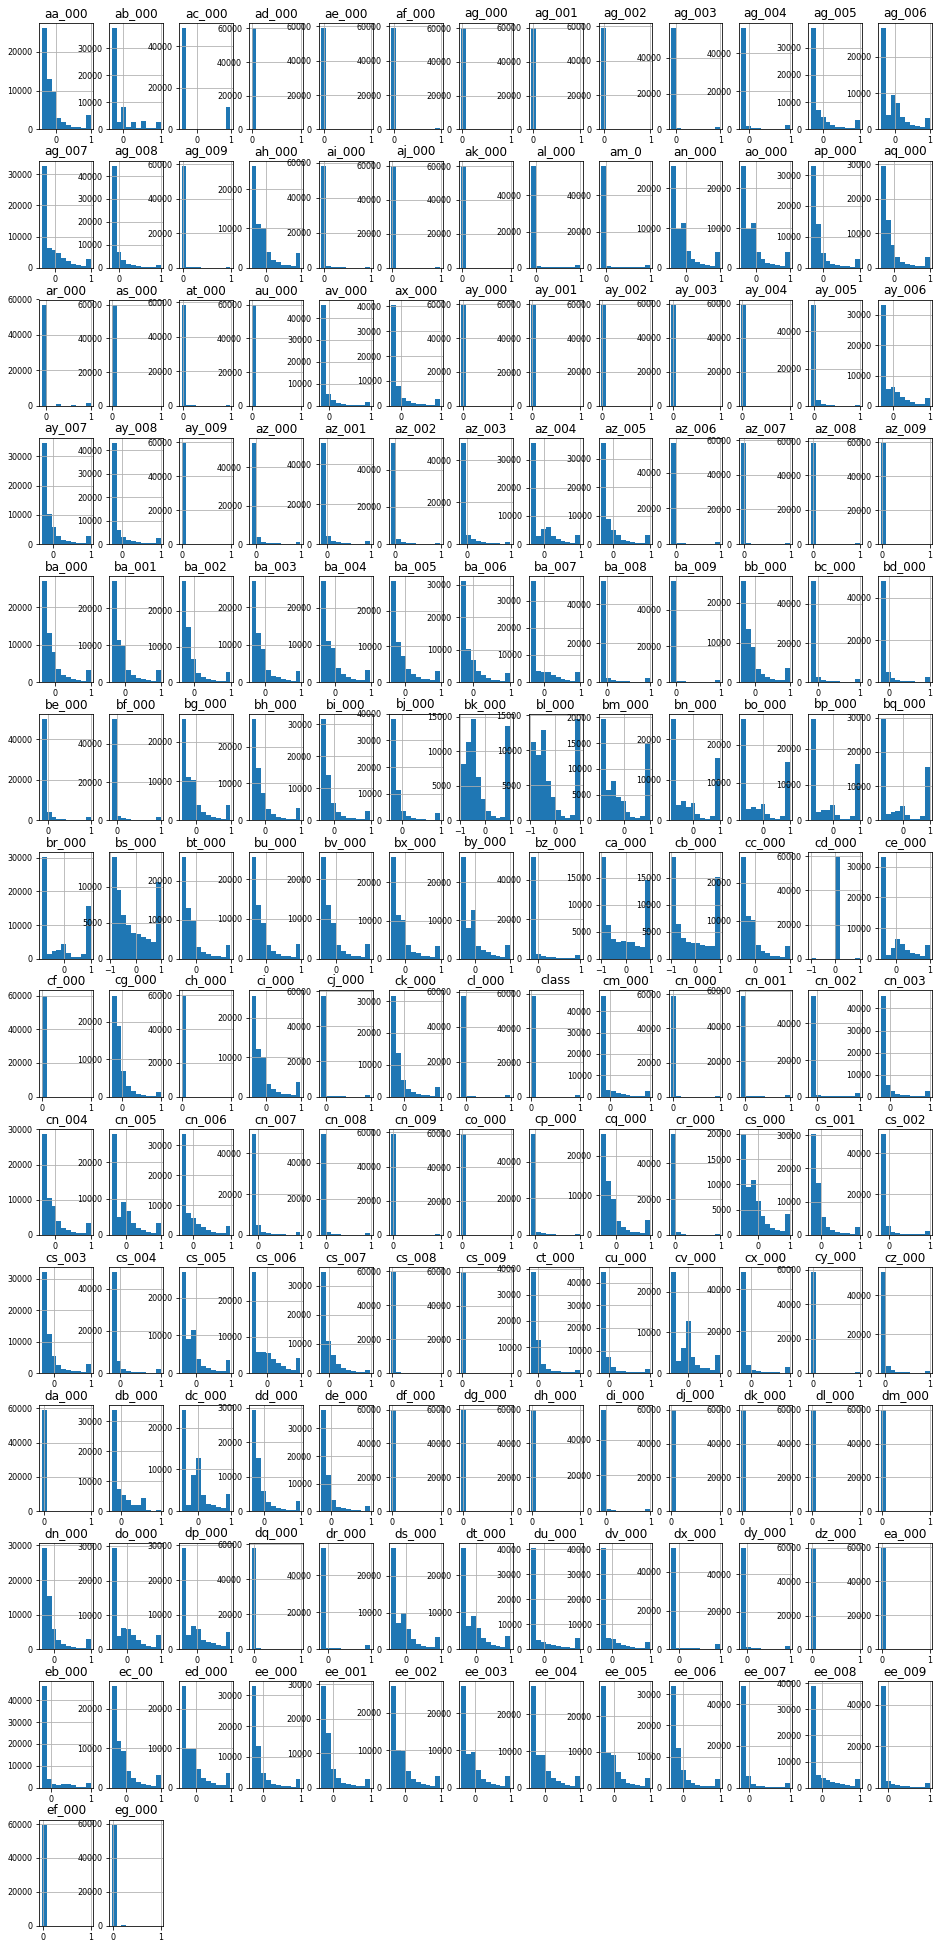

In [18]:
df_train.hist(figsize=(16,35),bins=10,xlabelsize=8,ylabelsize=8);

In above plots, there are 24 attributes share a similar distribution to the 'class' distribution.

> Build Logistic Regresson model

In [19]:
lr=LogisticRegression()
lr.fit(X_train,y_train);

In [20]:
#predict on test data
y_pred_lr=lr.predict(X_test)

In [21]:
#confusion matrix
cm=confusion_matrix(y_test,y_pred_lr,labels=[0,1])
cm

array([[15184,   441],
       [   25,   350]])

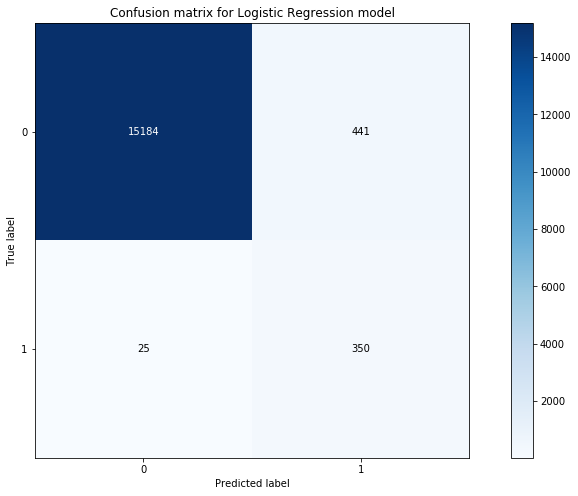

In [22]:
#Plot confusion matrix
skplot.metrics.plot_confusion_matrix(y_test,y_pred_lr,figsize=(15,8),title='Confusion matrix for Logistic Regression model')

Out of 16000 test instances, 97.08% of instances are classified correctly & remaining 2.91% instances are misclassified.

> Build a LghtGBM model

In [23]:
#load datasets in lgb formate
train_data=lgb.Dataset(X_train,label=y_train)

In [24]:
#Create the validation dataset
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
print("The shape of X_train is : {} & the shape of y_train is : {}".format(X_train.shape,y_train.shape))
print("The shape of X_val is : {} & the shape of y_val is : {}".format(X_val.shape,y_val.shape))
validation_data=lgb.Dataset(X_val,label=y_val)

The shape of X_train is : (106200, 170) & the shape of y_train is : (106200,)
The shape of X_val is : (11800, 170) & the shape of y_val is : (11800,)


In [25]:
#set parameters for training
params={ 'num_leaves':145,
        'object':'binary',
        'metric':['auc','binary_logloss']
       }

In [26]:
#Train the model
num_round=20
lgb_model=lgb.train(params,train_data,num_round,valid_sets=validation_data,early_stopping_rounds=5)


[1]	valid_0's binary_logloss: 0.601919	valid_0's auc: 0.996006
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.52688	valid_0's auc: 0.996648
[3]	valid_0's binary_logloss: 0.464286	valid_0's auc: 0.997227
[4]	valid_0's binary_logloss: 0.410542	valid_0's auc: 0.997555
[5]	valid_0's binary_logloss: 0.364685	valid_0's auc: 0.99794
[6]	valid_0's binary_logloss: 0.325297	valid_0's auc: 0.997954
[7]	valid_0's binary_logloss: 0.290813	valid_0's auc: 0.998089
[8]	valid_0's binary_logloss: 0.260741	valid_0's auc: 0.998349
[9]	valid_0's binary_logloss: 0.234461	valid_0's auc: 0.998512
[10]	valid_0's binary_logloss: 0.210964	valid_0's auc: 0.998565
[11]	valid_0's binary_logloss: 0.190287	valid_0's auc: 0.998766
[12]	valid_0's binary_logloss: 0.171868	valid_0's auc: 0.998986
[13]	valid_0's binary_logloss: 0.15578	valid_0's auc: 0.999139
[14]	valid_0's binary_logloss: 0.141502	valid_0's auc: 0.999365
[15]	valid_0's binary_logloss: 0.12862	valid_0's auc: 0

In [27]:
#Prediction on unseen dataset
y_pred=lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration)>0.5

In [28]:
#Confusion matrix
cm=confusion_matrix(y_test,y_pred,labels=[0,1])
cm

array([[15458,   167],
       [   63,   312]])

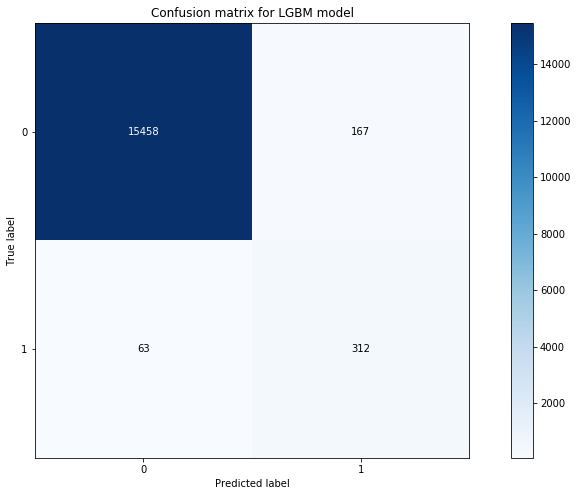

In [29]:
#Plot confusion matrix
skplot.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(15,8),title='Confusion matrix for LGBM model')
plt.show()

Out of 16000 test instances, 98.56% of instances are classified correctly & remaining 1.43% instances are misclassified.

The LGBM model performed well on test dataset than logistic regression model. The performance of LGBM model improved further by optimizing the hyper parameters.